In [ ]:
#Wir importieren die benötigten Bibliotheken

#algebrische Datentypen a'la matlab.
import numpy as np

#angepasste Plot-Funkionen
from libtank import plot_results

#allgemeine Plot-Funkionen a'la Matlab
import matplotlib.pyplot as pp

#Funktion für die Simulation der Modelle
from scipy.integrate import solve_ivp

#allgemeinen Funktionen für MIMO-Systeme
import libmimo as mimo

#zum einacheren Handling von Reimporten geänderter Bibliotheken
import importlib as imp

#Computeralgebra (Hier nur für die Ausgabe)
import sympy



In [ ]:
#Parameter des Viertank-Systems importieren
import settings as st

#Interessierende Ruhelagen anhand der Ausgänge y1=x3 und y2=x3 definieren
y1 = np.array([0.15,0.15])
y2 = np.array([0.10,0.20])
y3 = np.array([0.22,0.05])
y4 = np.array([0.17,0.13])
y5 = np.array([0.13,0.17])

y_equi=[y1,y2,y3,y4,y5]

#zu betrachtende Übergänge (RL2 nach RL3 sowie RL4 nach RL5) laut Aufgabenstellung
transitions = [(2,3),
               (4,5)]



# 1 Modelle des Tanksystems

## a) Nichlineares Modell

Implementieren Sie das nichtlineare Modell, wie in der Aufgabenstellung beschrieben.

### Dokumentation: Nichtlineares Modell des Viertanksystems

Das Viertanksystem beschreibt die Dynamik der Füllstände $x_1, x_2, x_3, x_4$ in vier miteinander verbundenen Tanks. Die zeitliche Änderung der Füllstände basiert auf einer Volumenbilanz, die für jeden Tank formuliert wird. Die allgemeine Form lautet:

$$
\dot{x}_i(t) = \frac{1}{A_T} \left( Q_{\text{in}, i}(t) - Q_{\text{out}, i}(t) \right),
$$

wobei $A_T$ die Querschnittsfläche der Tanks darstellt, $Q_{\text{in}, i}(t)$ die Zuflüsse in Tank $i$ und $Q_{\text{out}, i}(t)$ die Abflüsse aus Tank $i$ beschreibt. (ist das korrekt so?)

Die Zuflüsse in das System werden durch die Pumpen erzeugt, deren Volumenströme proportional zur Spannung $u_i(t)$ sind. Das Pumpenmodell lautet:

$$
Q_{\text{zu}, i}(t) =
\begin{cases}
K_U \cdot (u_j(t) - u_{0j}), & \text{für } u_j(t) <= u_{0j}, \\
0, & \text{sonst}.
\end{cases}
$$

Die Abflüsse zwischen den Tanks sowie ins Reservoir folgen dem Torricelli-Gesetz, das durch folgende Gleichung beschrieben wird:

$$
Q_{ij}(t) = a_{ij} \cdot \sqrt{2 \cdot g \cdot (x_i(t) + h_v)},
$$

wobei $a_{ij}$ der wirksame Abflussquerschnitt zwischen Tank $i$ und $j$ ist, $g$ die Erdbeschleunigung und $h_v$ die Höhe des Ventils unterhalb des Tankbodens. Diese gleichung gilt nur solange $x_i(t) >= -h_v$, also solange der Füllstand unterhalb Füllhöhe ist. Sobald dies nicht mehr gilt ist der Abfluss $Q_{ij}(t) = 0 $

Ausgehend von diesen physikalischen Grundlagen ergeben sich die Differentialgleichungen des Viertanksystems. Diese können aius den gegebenen Gleichungen 4a-4d hergeleitet werden: (hier muss noch beachtet werden wenn x > 0 ist!!!)

1. Für Tank 1:
$$
\dot{x}_1(t) = \frac{1}{A_T} \left( Q_{01}(t) - Q_{12}(t) - Q_{13}(t) \right),
$$
1. Für Tank 2:
$$
\dot{x}_2(t) = \frac{1}{A_T} \left( Q_{02}(t) + Q_{12}(t) - Q_{23}(t) - Q_{24}(t) \right),
$$
1. Für Tank 3:
$$
\dot{x}_3(t) = \frac{1}{A_T} \left( Q_{13}(t) + Q_{23}(t) - Q_{34}(t) - Q_{30}(t) \right),
$$
1. Für Tank 4:
$$
\dot{x}_4(t) = \frac{1}{A_T} \left( Q_{24}(t) + Q_{34}(t) - Q_{40}(t) \right).
$$

Die Implementierung des Modells erfolgt in der Funktion `model`, welche die Zuflüsse mit der Methode `get_flow_from_input` und die Abflüsse mit der Methode `get_outflow_from_level` berechnet. Die berechneten Zuflüsse und Abflüsse werden in die oben genannten Differentialgleichungen eingesetzt, um die Zustandsänderungen $\dot{x}(t)$ zu berechnen. Das Modell bildet die Grundlage für die Simulation und Analyse der Dynamik des Viertanksystems.
Um Den Ausgang (Die Funktion `output`) korrekt aufzustellen, werden die Tanks 3 und 4 betrachtet. Je nachdem ob die angegebene Zeit ein bestimmter Zeitpunkt (float) oder eine Zeitreihe (array) ist, werden die Tanks betrachtet...

In [ ]:
#Reimport der Viertank-Bibliothek
import libtank
imp.reload(libtank)
from libtank import VierTank;

#Modell prüfen
tank=VierTank(st)

tank.verify_model("testdata.pckl")

Maximaler absoluter Fehler in Modellgleichung (euklidische Norm): 1.5978378594934195
Maximaler relativer Fehler in Modellgleichung (euklidische Norm): 34.419632451924166
Maximaler absoluter Fehler in Ausgangsgleichung (euklidische Norm): 0.0
Maximaler relativer Fehler in Ausgangsgleichung (euklidische Norm): 0.0


Wenn die Fehler gering sind, verhält sich das aufgestellte Modell gut zu den Testdaten.

## b) Bestimmung der Ruhelagen

Ergänzen Sie hier hier Ihre Überlegungen zur Bestimmung der Ruhelagen und implementieren Sie das Ergebnis in der Methode `equilibrium` der Klasse `VierTank`.

Die nächste Zelle dient zunächst zum Test Ihrer Implementierung: Wenn die Ruhelagen in die Modellgleichungen eingesetzt werden, sollte  

Die Ruhelagen können bestimmt werden, indem die zeitlichen Größen der Zustandsgrößen gleich Null sind. Außerdem sollte überprüft werden, ob die gefunden Ruhelagen auch innerhalb der systembedingten Grenzen liegen und physikalisch möglich sind.

Die dynamischen Gleichungen des Systems lauten:

$ A_1 \dot{x}_1 = Q_{01} - Q_{12} - Q_{13}, \quad A_2 \dot{x}_2 = Q_{02} + Q_{12} - Q_{23} - Q_{24}, $ $ A_3 \dot{x}_3 = Q_{13} + Q_{23} - Q_{34} - Q_{30}, \quad A_4 \dot{x}4 = Q{24} + Q_{34} - Q_{40}. $

Die Ausgänge sind direkt durch $y_1 = x_3$ und $y_2 = x_4$ gegeben. Daher werden die Werte von $x_3$ und $x_4$ zunächst fixiert. Aus den Abflussvolumenströmen ergeben sich:

$ Q_{34} = a_{34} \sqrt{2 g (x_3 + h_V)}, \quad Q_{40} = a_{40} \sqrt{2 g (x_4 + h_V)}. $

Darauf basierend werden mögliche Werte für $x_2$ iterativ berechnet:

$ Q_{23} = a_{23} \sqrt{2 g (x_2 + h_V)}, \quad Q_{24} = a_{24} \sqrt{2 g (x_2 + h_V)}. $

Aus $x_2$ folgt $x_1$:

$ Q_{12} = a_{12} \sqrt{2 g (x_1 + h_V)}, \quad Q_{13} = a_{13} \sqrt{2 g (x_1 + h_V)}. $

Die Eingangsspannungen ergeben sich über die Zuflussvolumenströme:

$ Q_{01} = Q_{12} + Q_{13}, \quad Q_{02} = Q_{23} + Q_{24}, $

und die Pumpenkennlinien:

$ u_1 = u_{A0,1} + \frac{Q_{01}}{K_{u1}}, \quad u_2 = u_{A0,2} + \frac{Q_{02}}{K_{u2}}. $

Dabei gelten die Beschränkungen $0 \leq x_i \leq h_T$, $u_1, u_2 \leq u_{A\text{max}}$, und alle Volumenströme müssen positiv sein. Durch numerische Iteration werden gültige Ruhelagen berechnet und in der $y_1$-$y_2$-Ebene dargestellt. Dies wird im Code entsprechend implementiert, indem die Funktion ´equilibrium´ vervollständigt wird.

In [ ]:
#Reimport der Viertank-Bibliothek
import libtank
imp.reload(libtank)
from libtank import VierTank;

tank=VierTank(st)

equis=[]

#Berechnung der zugehörigen Ruhelagenzustände und Eingänge
for i_, y_ in enumerate(y_equi):
    #Ruhelage berechnen
    _equi=tank.equilibrium(y_)
    equis.append(_equi)

    # Prüfen: hier sollte möglichst 0 herauskommen
    dx_equi = tank.model(0, _equi.x, lambda t,x:_equi.u)
    print("Ableitungstest Ruhelage " + str(i_+1) + ": " + str(dx_equi))

Ableitungstest Ruhelage 1: [-2.15695169e-17 -1.07847584e-17  0.00000000e+00  0.00000000e+00]
Ableitungstest Ruhelage 2: [ 3.23542753e-17 -2.15695169e-17  0.00000000e+00 -4.31390338e-17]
Ableitungstest Ruhelage 3: [ 2.15695169e-17 -5.39237922e-18  0.00000000e+00  0.00000000e+00]
Ableitungstest Ruhelage 4: [ 3.23542753e-17 -2.15695169e-17  1.07847584e-17  0.00000000e+00]
Ableitungstest Ruhelage 5: [-1.07847584e-17  3.23542753e-17  0.00000000e+00  0.00000000e+00]


Das Ergebniss des Ableitungstest zeigt, dass die Zahlen nahe 0 sind, somit ist dies zulässig (???)

Auf der Basis wird nun eine Grafik aller zulässigen Ruhelagen erstellt. Hier ist lediglich

NameError: name 'pc' is not defined

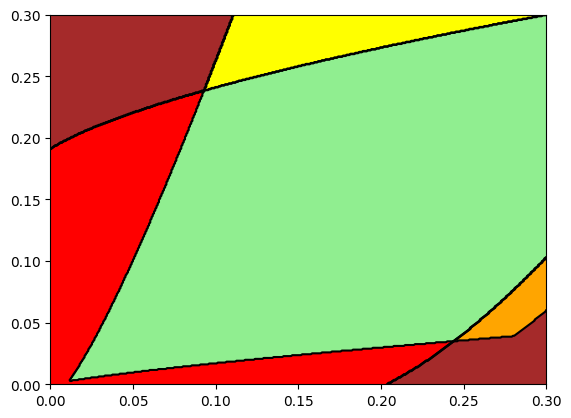

In [ ]:
#Reimport der Viertank-Bibliothek
import libtank
imp.reload(libtank)
from libtank import VierTank;

#Bestimmen aller zulässigen Ruhelagen
tank=VierTank(st)

#Auflösung
N=401
M=np.zeros((N,N))

#Stützstellen Ausgangsfüllhöhen
_y1_array=np.linspace(0,0.3,N)
_y2_array=np.linspace(0,0.3,N)

#Ruhelagen zu allen Stütstellen berechnen
for _i, _y1 in enumerate(_y1_array):
    for _j, _y2 in enumerate(_y2_array):
        _equi = tank.equilibrium([_y1,_y2])
        color_code = [0,1,2,4,3,4,4,4]
        M[_j,_i]=color_code[_equi.status]


#Plotten
fig = pp.figure();
cs=pp.contourf(_y1_array,_y2_array,M,[-0.5,0.5,1.5,2.5,3.5,4.5],colors=['lightgreen','red','yellow','orange','brown'])
pp.contour(_y1_array,_y2_array,M,[-0.5,0.5,1.5,2.5,3.5,4.5],colors='black')
ax=pp.gca()
ax.set_xlim(0,0.3)
ax.set_ylim(0,0.30)


labels=["Admissible","Negative or small Volume Flow","Maximum Fluid Level Exceeded","Pump Voltage exceeded","Multiple issues"]
proxy = [pp.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0])
        for pc in cs.collections]
pp.legend(proxy, labels,bbox_to_anchor=(1.7, 1.02))
for _i in range(len(labels)):
    cs.collections[_i].set_label(labels[_i])
#for _i,_y in enumerate(y_equi):
pp.plot(np.array(y_equi)[:,0],np.array(y_equi)[:,1],"kx")
pp.grid()
pp.show()


## c) Simulation des nichtlinearen Modells

Führen Sie an dieser Stelle die Simulationsstudie des nichtlinearen Modells durch und interpretieren Sie die Ergebnisse. An dieser Stelle ist keine Programmierarbeit zu leisten.

In [ ]:
#Modell neu laden
import libtank
imp.reload(libtank)
from libtank import VierTank;
tank=VierTank(st)

# Ein "Regler" der den Eingang konstant hält
def constant_controller(t,x,u):
    if x.ndim==1:
        return u
    else:
        return np.diag(u)@np.ones((2,x.shape[1]))

#Simulationszeit
Tsim=400

for _i, _transition in enumerate(transitions):

    #Anfangszustand
    _x0 = equis[_transition[0]-1].x

    #Endzustand
    _x1 = equis[_transition[1]-1].x

    #konstantes Stellsignal ensprechend Endruhelage
    _u0 = equis[_transition[1]-1].u


    #Auswertungszeitpunkte
    t_eval=np.linspace(0,Tsim,1000)

    #Wrapper für rechte Seite der Differentialgleichung
    _ctrl = lambda t,x: constant_controller(t,x,_u0)
    _rhs = lambda t,x:tank.model(t,x,_ctrl)

    #Modell simulieren
    res = solve_ivp(_rhs,#zu simulierendes Modell
                    [0,Tsim],#Zeitspanne für Simulation
                    _x0,#Anfangszustand
                    t_eval=t_eval,#Auswertungszeitpunkte
                    atol=1e-6,rtol=1e-3 #Toleranzen
                    )

    #Ergebnisse Plotten
    x=res.y
    u=_ctrl(t_eval,x)
    _xx=np.tile(_x1,(t_eval.shape[0],1)).T
    plot_results(t_eval,(_xx,x),(u,))
    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()

Die beiden Grafiken zeigen den Übergang von einer Ruhelage in die nächste.
#### Übergang Ruhelage 2 zu 3
??

## d) Lineares Modell des Tanksystems

Fügen Sie hier Ihre Überlegungen zur Linearisierung ein. Die Ergebnisse sind in der Methode `linearize` der Klasse `VierTank`zu implementieren. Aus der nächsten Zelle werden die Ergebnisse aufgerufen und numerisch überprüft. Es werden ausserdem die Eigenwerte entsprechenden Systemmatrizen berechnet. Interpretieren Sie anhand dieser Eigenwerte kurz die Simulationsergebnisse der vorangegangenen Teilaufgabe.

Für die Linearisierung um eine beliebeige Ruhelage, wird die Ruhelage an die Funktion übergeben. Für diese werden dann die numerische Berechnungen der Ableitungen durchgeführt. Es werden also die Jacobi-Matrizen (welche die Systemmatrizen darstellen) berechnet. Um die Ableitungen zu bilden wird die Methode der finiten Differenzen verwendet. (Passt das so oder sollten wir was anderes machen?)
((Um die partielle Ableitung zu approximieren, wird eine kleine Störungder Zustandsvariable $x$ und Eingangsvariable $u$ verwendet)) Das ist falsch meiner Meinung nach!!

In [ ]:
#Modell neu laden
import libtank
imp.reload(libtank)

from libtank import VierTank;

tank=VierTank(st)

for _i, y_ in enumerate(y_equi):
    print("Ruhelage "+ str(_i+1) +":")
    print("===========")
    #Prüfen des Regimes
    _equi=tank.equilibrium(y_)

    #Berechnung der Linearisierung
    tank_lin = tank.linearize(_equi)

    #Prüfen der Linearisierung
    A,B,C=tank.verify_linearization(tank_lin)

    #Eigenwerte berechnen
    print("Eigenwerte : " + str(np.linalg.eigvals(tank_lin.A)))
    print()


Zuletzt sollen sie Eigenwerte der Systemmatrizen numerisch berechnet werden. Dies geschieht bereits im vorgesetzten Code und wird deshalb nicht erneut durchgeführt. Fehlend: Interpretation der Simulationsergebnisse in Hinblick auf die Eigenwerte?

# 2 Zeitkontinuierlicher Entwurf

In [ ]:
#In diesem Abschnitt wird durchgehend die Ruhelage 1 für den Entwurf genutzt
tank=VierTank(st)
tank_lin=tank
tank_lin = tank.linearize(equis[0])

#Übergangszeit ist jeweils 50s
T=50.0

## a) Steuerbarkeit

Ergänzen Sie hier Ihre Überlegungen zu Teilaufgab a).

Die Steuerbarkeit des linearisierten Systems kann mithilfe des Kalmannschen Kriteriums gelöst werden. Ein System ist steuerbar, wenn die Steuerbarkeitsmatrix S vollen Rang n besitzt. Zuerst wird also S berechnet, wobei die Matrizen A und B aus der linearen Zustandsraumdarstellung des Systems in Ruhelage 1 verwendet werden. Hierfür wird mit der Methode `linearize` aus `libtank.py` die Systemmatrizen berechnet.

$S = \begin{bmatrix} B & AB & A^2B & \cdots & A^{n-1}B \end{bmatrix}$

Die Steuerbarkeitsmatrix kann mit der Funktion  `controllability_matrix` in der Datei `libmimo.py` berechnet werden.


Weiter wird mithilfe des Rangs überprüft ob das System steuerbar ist, dabei gilt: Das Sytem ist steuerbar, wenn $\text{Rang}(S) = n$, wobei $n$ der Anzahl der Zustandsvariablen entspricht.

Kronecker-Indizes: Die Kronecker-Indizes $\nu_i$ ergeben sich aus der Struktur der Steuerbarkeitsmatrix $S$ und beschreiben die Länge der Steuerbarkeitsketten im System in Regelungsnormalform. Diese Ketten geben an, wie die Zustandsvariablen des Systems durch die Eingabe u(t)u(t) beeinflusst werden können, sie entsprechen der Minmialen Anzahl von Zustandsvariablen , die erforderlich sind um das System vollständig zu steuern. Ihre Summe entspricht $n$.

In [ ]:
# Hier den Code zu Teilaufgabe a) ergänzen
# Import der notwendigen Funktionen
from libmimo import controllability_matrix

# Zugriff auf die Systemmatrizen
A, B, C, D = tank_lin.A, tank_lin.B, tank_lin.C, tank_lin.D

# Steuerbarkeitsmatrix berechnen
S = controllability_matrix(A, B)

# Rang der Steuerbarkeitsmatrix überprüfen
rank_S = np.linalg.matrix_rank(S)
state_dim = A.shape[0]

if rank_S == state_dim:
    print("Das System ist steuerbar.")
else:
    print("Das System ist nicht steuerbar.")

# Bestimmung der Kronecker-Indizes
# Hier wird weiter analysiert, z.B. Blockstruktur oder Transformation


Das system ist steuerbar. Die Kronecker Indizes ...
Sollen diese noch explizit berechnet werden?

## b) Trajektorienplanung

Ergänzen Sie hier Ihre Überlegungen zu Teilaufgabe b).

Führen Sie die in der Angabe angegebenen Anpassungen der Algorithmen in der Klasse `ContinuousFlatnessBasedTrajectory` in der Datei `libtank.py` durch.

Interpretieren Sie Anhand der Transformationsmatrix $Q$ auf Regelungsnormalform die Bedeutung des flachen Ausgangs (mündlich).

In [ ]:
from libmimo import mimo_rnf

## Hier die Kommentare entfernen und Interpretation des flachen Ausgangs anhand der Matrix Q diskutieren

#mimo_rnf(tank_lin.A,tank_lin.B,tank_lin.C,(2,2))
#_, _, _,_, Q, S = mimo_rnf(tank_lin.A,tank_lin.B,tank_lin.C,(2,2))
#display(sympy.Matrix(Q.round(2)))

## c) Steuerungsentwurf

Testen Sie hier Ihre Implementierung und interpretieren Sie die Ergebnisse.

In [ ]:
#importiere benötigte Funktion
imp.reload(libtank)

#Übergangszeit für Trajektorie
Tsim=2*T

#Übergangszeit bitte ggf. anpassen
T = [150,50]

#Generiere Solltrajektorien für das linearisierte System
for _i, _transition in enumerate(transitions):

    _T = T[_i]

    #Simulationszeit

    Tsim = 2*_T

    #Anfangs- und Endruhelage abrufen
    _ya = y_equi[_transition[0]-1]
    _yb = y_equi[_transition[1]-1]

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Ergebnisse Plotten
    tv=np.linspace(0,Tsim,1000)
    _x_soll = _trajectory.state(tv)
    _u_soll = _trajectory.input(tv)
    plot_results(tv,(_x_soll,),(_u_soll,))
    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()




Zum Test der bisherigen Schritte wird die Planung mit der Simulation verglichen. Zumindest bei der Simulation mit dem linearen Modell sollten die geplanten und die simulierten Trajektorien jeweils übereinanderliegen.

## d) Simulation der Steuerung

In [ ]:
linear = False

#Übergangszeit für die beiden Szenarien bitte ggf. anpassen
T = [50,50]

tank = VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank

for _i, _transition in enumerate(transitions):
    #Übergangszeit auslesen
    _T = T[_i]

    #Simulationszeit

    _Tsim = 2*_T

    #Anfangs- und Endwerte
    _ya = y_equi[_transition[0]-1]
    _yb = y_equi[_transition[1]-1]

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Auswertungszeitpunkte
    t_eval=np.linspace(0,_Tsim,1000)

    #Anfangszustand
    if linear:
        x0 = _trajectory.state(0)
    else:
        x0 = equis[_transition[0]-1].x


    #Solltrajektorien auswerten
    _x_soll = _trajectory.state(t_eval)
    _u_soll = _trajectory.input(t_eval)


    #Wrapper für rechte Seite der Differentialgleichung
    _ctrl = lambda t,x:_trajectory.input(t)
    _rhs = lambda t,x:_tank.model(t,x,_ctrl)

    #Simulation
    res = solve_ivp(_rhs,#zu simulierendes Modell
                    [0,Tsim],#Zeitspanne für Simulation
                    x0,#Anfangszustand
                    t_eval=t_eval,#Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6 #Toleranzen
                    )

    #Ergebnisse Plotten
    _x=res.y
    plot_results(t_eval,(_x_soll,_x),(_u_soll,))
    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()


## e) Reglerentwurf

In [ ]:
# Definition einer generischen Zustandsrückführung mit Führungsgrößenaufschaltung
def controller_closed_loop(t,x,K,trajectory):
    #skalare Argumente vektorisieren
    tv=np.atleast_1d(t)

    #Sollzustand berechnen
    x_ref=trajectory.state(tv)

    if np.isscalar(t):
        #Dimension testen, eventuell auf Matrixform bringen
        x_=np.array(x).reshape(4,1)
    else:
        x_=x

    #Regelfehler
    x_tilde=x_-x_ref

    ######-------!!!!!!Aufgabe!!!!!!-------------########
    #Hier bitte die vollständige Zustandsrückführung für das nichtlineare System einfügen
    u = np.zeros((2,tv.shape[0]))
    ######-------!!!!!!Aufgabe Ende!!!!!!-------########

    if np.isscalar(t):
        u=u[:,0]
    return u

### Berechnen der Reglerverstärkungen

Fügen Sie hier Ihre Überlegungen zur Reglerauslegung ein.

In [ ]:
#Eigenwerte des offenen Kreises

######-------!!!!!!Aufgabe!!!!!!-------------########
#hier bitte Wunscheigenwerte des geschlossenen Regelkreises wählen und Reglerverstärkungen berechnen
K_pole_placement=np.zeros((2,4))
######-------!!!!!!Aufgabe Ende!!!!!!-------########

print(K_pole_placement)

print("Reglerverstärkung:")
display(sympy.Matrix(K_pole_placement.round(3)))

print("Probe (Eigenwerte geschlossener Kreis):")
display(sympy.Matrix(np.linalg.eigvals(tank_lin.A-tank_lin.B@K_pole_placement).round(3)))

print("Eigenwerte Zielregime:")
display(sympy.Matrix(np.linalg.eigvals(tank.linearize(equis[2]).A-tank.linearize(equis[2]).B@K_pole_placement).round(3)))

### Simulation des geschlossenen Regelkreises

Passen Sie die Parameter selbständig an

In [ ]:
#Simulationsmodell linear oder nichtlinear
linear = False

#Übergangszeit für gewählte Übergänge (bitte ggf. anpassen)
T = [50,50]

tank = VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank

for _i, _transition in enumerate(transitions):
    #Übergangszeit auslesen
    _T = T[_i]

    #Simulationszeit

    Tsim = 2*_T

    #Anfangs- und Endwerte
    _ya = y_equi[_transition[0]-1]
    _yb = y_equi[_transition[1]-1]

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Auswertungszeitpunkte
    t_eval=np.linspace(0,Tsim,1000)


    #Anfangszustand
    if linear:
        _x0 = _trajectory.state(0)
    else:
        _x0 = equis[_transition[0]-1].x

    #Wrapper für Regler und System
    _ctrl = lambda t_,x_:controller_closed_loop(t_, x_,K_pole_placement,_trajectory)
    _rhs = lambda t_, x_:_tank.model(t_,x_,_ctrl)



    #Simulation
    res = solve_ivp(_rhs,#zu simulierendes Modell
                    [0,Tsim],#Zeitspanne für Simulation
                    _x0,#Anfangszustand
                    t_eval=t_eval,#Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6 #Toleranzen
                    )

    #Ergebnisse Plotten
    _x = res.y
    _u = _ctrl(t_eval,_x)

    #Ergebnisse Plotten
    plot_results(t_eval,
                 (_trajectory.state(t_eval),_x),
                 (_trajectory.input(t_eval),_u))

    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()


## f) LQR Entwurf

Ergänzen Sie hier Ihre Überlegungen zum LQR-Entwurf. Die Berechnung der Reglerverstärkungen sind in der nächsten Zelle zu implementieren.

In [ ]:
import libtank
imp.reload(libtank)

R=np.eye(2)
Q=np.eye(4)
print("Gewichtsmatrix Q:")
display(sympy.Matrix(Q.round(3)))

print("Gewichtsmatrix R:")
display(sympy.Matrix(R.round(3)))

K_lqr=tank_lin.lqr(Q,R)

print("Reglerverstärkung:")
display(sympy.Matrix(K_lqr.round(3)))

In [ ]:
linear = False

#Übergangszeit bitte ggf. anpassen
T = [100,100]

tank = VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank

for _i, _transition in enumerate(transitions):
    #Übergangszeit auslesen
    _T = T[_i]

    #Simulationszeit

    Tsim = 2*_T

    #Anfangs- und Endwerte
    _ya = y_equi[_transition[0]-1]
    _yb = y_equi[_transition[1]-1]

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Auswertungszeitpunkte
    t_eval=np.linspace(0,Tsim,1000)


    #Anfangszustand
    if linear:
        _x0 = _trajectory.state(0)
    else:
        _x0 = equis[_transition[0]-1].x

    #Wrapper für Regler und System
    _ctrl = lambda t,x:controller_closed_loop(t,x,K_lqr,_trajectory)
    _rhs = lambda t,x:_tank.model(t,x,_ctrl)



    #Simulation
    res = solve_ivp(_rhs,#zu simulierendes Modell
                    [0,Tsim],#Zeitspanne für Simulation
                    _x0,#Anfangszustand
                    t_eval=t_eval,#Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6 #Toleranzen
                    )

    #Ergebnisse Plotten
    _x = res.y
    _u = _ctrl(t_eval,_x)

    #Ergebnisse Plotten
    plot_results(t_eval,
                 (_trajectory.state(t_eval),_x),
                 (_trajectory.input(t_eval),_u))

    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()


# 3 Zeitdiskreter Entwurf
Das zeitdiskrete Simulationsmodell ist im wesentlichen als Schleife aufgebaut. In jedem Abtastschritt wird zunächst der Eingang aktualisiert. Im Anschluss wird das System, mit diesem Wert für den Eingang, über eine Abtastperiode simuliert.

In [ ]:
def simulate_discrete(sys,x0,fkt_u,Ta,Tsim):
    #nonlinear simulation
    t_array=np.array([])
    u_array=np.zeros((2,0))
    x_array=np.zeros((len(x0),0))
    k=0
    while k*Ta<Tsim:
        u=fkt_u(k,x0)
        ctrl = lambda t,x:u
        rhs=lambda t,x:sys(t,x,ctrl)
        t_eval=[k*Ta,(k+0.01)*Ta,(k+0.99)*Ta,(k+1)*Ta]
        res=solve_ivp(rhs,[k*Ta,(k+1)*Ta],x0,atol=1e-9,rtol=1e-6,t_eval=t_eval)
        t_array=np.hstack((t_array,res.t))
        x_array=np.hstack((x_array,res.y))
        u_array=np.hstack((u_array,u.reshape((2,1))*np.ones_like(res.t)))
        k+=1
        x0=x_array[:,-1]

    return t_array,x_array,u_array

Für alle nachfolgenden zeitdiskreten Schritte muss zunächst das Systemmodell mit der gewählten Abtastschrittweite $T_a$ diskretisiert werden.

## a) Quasi-kontinuierliche Simulation

In [ ]:
#Simulation mit linearem Entwurfsmodell oder nichtlinearem Modell?
linear = True

#Abtastzeiten
Ta = [1.0, 5.0, 10.0]

#Simulationszeit
Tsim=200

tank = VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank

#Auswertungszeitpunkte
t_eval=np.linspace(0,Tsim,500)

_transition = transitions[1]
_ya = y_equi[_transition[0]-1]
_yb = y_equi[_transition[1]-1]

for _Ta in Ta:
    #Anfangszustand
    if linear:
        _x0 = _trajectory.state(0)
    else:
        _x0 = equis[_transition[0]-1].x

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Wrapper für Regler und System
    _ctrl = lambda k_,x_:controller_closed_loop(k_ * _Ta, x_, K_pole_placement,_trajectory)
    _rhs = lambda t, x, ctrl_:_tank.model(t, x, ctrl_)

    #Zeitdiskrete Simulation
    t_sim,x_sim,u_sim=simulate_discrete(_rhs, _x0, _ctrl, _Ta, Tsim)

    #Ergebnisse Plotten
    x_desired = _trajectory.state(t_sim)
    u_desired = _trajectory.input(np.floor(t_sim/_Ta)*_Ta)


    plot_results(t_sim,
                 (x_desired,x_sim),
                 (u_desired,u_sim))

## b) Ergänzen Sie hier kurz Ihre Gedanken zur Diskretisierung

## c) Zeitdiskreter Steuerungsentwurf

In [ ]:
linear=True

Ta=[5.0,15.0]

transition = transitions[1]
ya = y_equi[_transition[0]-1]
yb = y_equi[_transition[1]-1]

#Übergangszeit
T=50.0

#Simulationszeit
Tsim=200

tank=VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin

for _Ta in Ta:
    #Schritte für Übergang
    N=np.round(T/_Ta)

    #diskretes Modell
    tank_lin_discrete = tank_lin.discretize(_Ta)

    #Berechne diskrete Solltrajektorien
    trajectory_discrete = tank_lin_discrete.rest_to_rest_trajectory(ya, yb,N,[2,2])

    _ctrl = lambda k,x:trajectory_discrete.input(k)

    print("Anfangs und Endwerte flacher Ausgang:")
    print(trajectory_discrete.eta_a)
    print(trajectory_discrete.eta_b)

    #Wrapper für Modell
    if linear:
        _x0 = trajectory_discrete.state(0)
    else:
        _x0 = equis[_transition[0]-1].x

    _rhs = lambda t,x,controller:_tank.model(t, x, _ctrl)

    #Zeitdiskrete Simulation
    t_sim,x_sim,u_sim=simulate_discrete(_rhs, _x0, _ctrl, _Ta, Tsim)

    #Ergebnisse Plotten
    x_desired=trajectory_discrete.state(np.floor(t_sim/_Ta))
    u_desired=trajectory_discrete.input(np.floor(t_sim/_Ta))
    y_desired=trajectory_discrete.output(np.floor(t_sim/_Ta))

    plot_results(t_sim,
                 (x_desired,x_sim),
                 (u_desired,u_sim))
    pp.show()

## d) Zeitdiskreter Reglerentwurf

Ergänzen Sie hier Ihre Überlegungen zum zeitdiskreten Reglerentwurf.

In [ ]:
# Definition einer generischen diskreten Zustandsrückführung mit Führungsgrößenaufschaltung
def control_discrete_closed_loop(k,x,Kd,trajectory):
    kv=np.atleast_1d(k)
    x_desired=trajectory.state(kv)
    #Dimension testen, eventuell auf Matrixform bringen
    if np.isscalar(k):
        x_=np.array(x).reshape(4,1)
    else:
        x_=x
    x_tilde=x_-x_desired
    u_desired=trajectory.input(kv)
    u=u_desired-Kd@x_tilde
    if np.isscalar(k):
        u=u[:,0]
    return u

In [ ]:
#Simulation mit linarem oder nichtlinearem System?
linear = False

#LQR oder Eigenwertvorgabe?
lqr = False

#zu untersuchende Abtastzeiten
Ta=[5.0,10.0]

tank=VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank


transition = transitions[1]
ya = y_equi[_transition[0]-1]
yb = y_equi[_transition[1]-1]

#Übergangszeit
T=50.0

#Simulationszeit
Tsim=2*T

for _Ta in Ta:
    #Schritte für Übergang
    N=np.round(T/_Ta)

    #diskretes Modell
    tank_lin_discrete = tank_lin.discretize(_Ta)

    ######-------!!!!!!Aufgabe!!!!!!-------------########
    #Bitte vervollständigen / anpassen
    if lqr: # LQR-  Entwurf
        _Kd = tank_lin_discrete.lqr(Q,R)

    else: # Eikgenwertvorgabe
        _Kd = np.zeros((2,4))
    ######-------!!!!!!Aufgabe Ende!!!!!!-------########


    #Berechne diskrete Solltrajektorien
    trajectory_discrete = tank_lin_discrete.rest_to_rest_trajectory(ya,yb,N,[2,2])

    _ctrl = lambda k,x:control_discrete_closed_loop(k,x,_Kd,trajectory_discrete)

    print("Anfangs und Endwerte flacher Ausgang:")
    print(trajectory_discrete.eta_a)
    print(trajectory_discrete.eta_b)

    #Wrapper für Modell
    if linear:
        x0=trajectory_discrete.state(0)
    else:
        x0 = equis[_transition[0]-1].x
    _rhs = lambda t,x,controller : _tank.model(t,x,controller)


    #zeitdiskrete Simulation
    t_sim, x_sim, u_sim = simulate_discrete(_rhs,x0,_ctrl,_Ta,Tsim)

    #Ergebnisse Plotten
    x_desired=trajectory_discrete.state(np.floor(t_sim/_Ta))
    u_desired=trajectory_discrete.input(np.floor(t_sim/_Ta))

    plot_results(t_sim,
                 (x_desired,x_sim),
                 (u_desired,u_sim))

In [ ]:
tank.generate_model_test_data("testdata.pckl",200);
